# **💰 Project: Bitcoin Price Prediction with LSTM**
# Author: meytiii

Description:

This project demonstrates Time Series Forecasting using Deep Learning. We will fetch historical Bitcoin data using the Yahoo Finance API and train an LSTM (Long Short-Term Memory) neural network to predict future prices based on past trends.

This type of model is widely used in finance for analyzing temporal sequences.

In [1]:
# Install yfinance if not already present
!pip install -q yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Check GPU availability (LSTMs run faster on GPU)
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.19.0
Num GPUs Available:  1


# **1. Data Acquisition**
We use the yfinance library to grab the last 5 years of Bitcoin (BTC-USD) daily closing prices.

We then visualize the data to understand the trend we are trying to predict.

/tmp/ipython-input-3219954102.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


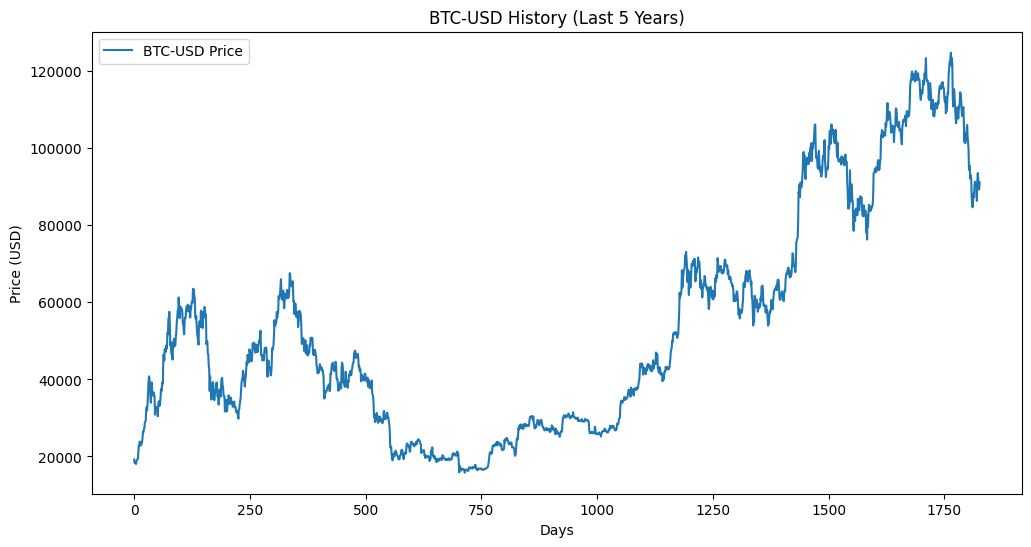

Total data points: 1827


In [2]:
# 1. Download Data
ticker = "BTC-USD"
data = yf.download(ticker, period="5y", interval="1d")

# 2. Focus only on "Close" price
# Use 'Close' column. .values converts it to a numpy array
prices = data[['Close']].values

# 3. Plot the history
plt.figure(figsize=(12, 6))
plt.plot(prices, label=f'{ticker} Price')
plt.title(f"{ticker} History (Last 5 Years)")
plt.xlabel("Days")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

print(f"Total data points: {len(prices)}")

# **2. Data Preprocessing & Scaling**
Neural networks work best with small numbers (between 0 and 1).

Scaling: We use MinMaxScaler to normalize the prices.

Sequence Creation: LSTMs need a "window" of past data to predict the future. We create a dataset where X is the past 60 days, and y is the price on the 61st day.

In [3]:
# 1. Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

# 2. Create Sequences
prediction_days = 60  # Look back 60 days to predict the next day

X_train, y_train = [], []

# We use 80% of data for training
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]

for x in range(prediction_days, len(train_data)):
    X_train.append(train_data[x-prediction_days:x, 0])
    y_train.append(train_data[x, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"Training data shape: {X_train.shape}")

Training data shape: (1401, 60, 1)


# **3. Building the LSTM Model**
We build a model with:

LSTM Layers: To capture time dependencies.

Dropout Layers: To prevent overfitting (randomly turning off neurons).

Dense Layer: To output the final predicted price.

In [4]:
model = tf.keras.Sequential([
    # Layer 1
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.2),

    # Layer 2
    tf.keras.layers.LSTM(units=50, return_sequences=False),
    tf.keras.layers.Dropout(0.2),

    # Output Layer
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# **4. Training**
We train the model. Since this is a regression task (predicting a number), we use 'loss' to measure error. Watch the loss go down!

In [5]:
model.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0234
Epoch 2/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0019
Epoch 3/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0019
Epoch 4/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0018
Epoch 5/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 6/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0016
Epoch 7/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 8/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013
Epoch 9/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012
Epoch 10/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0013
Epoch 11/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 12/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 13/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 14/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 15/25
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010    
Epoch 16/25

# **5. 🔮 Testing & Visualization**
Now we test the model on the remaining 20% of the data (data the model has never seen).

We will plot the Actual Prices vs the Predicted Prices to see how well our AI "trader" performed.



12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


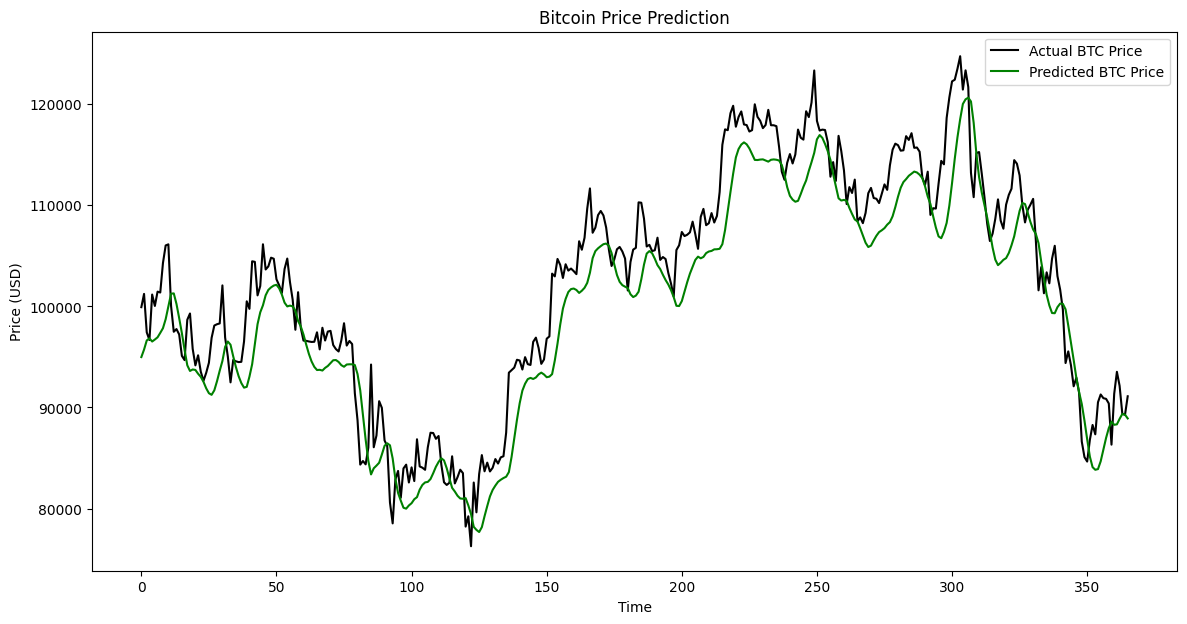

In [6]:
# 1. Prepare Test Data
test_data = scaled_data[train_size - prediction_days:]

X_test = []
y_test = prices[train_size:] # Actual prices for comparison

for x in range(prediction_days, len(test_data)):
    X_test.append(test_data[x-prediction_days:x, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 2. Make Predictions
predicted_prices = model.predict(X_test)

# 3. Inverse Transform (Convert back from 0-1 to USD)
predicted_prices = scaler.inverse_transform(predicted_prices)

# 4. Plot Results
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='black', label='Actual BTC Price')
plt.plot(predicted_prices, color='green', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()